In [1]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score

logging.basicConfig(level=logging.INFO)

In [2]:
# use_contrastive = False
use_contrastive = True
# num_tasks = 4
# num_init_tasks = 4

num_tasks = 1
num_init_tasks = 1

num_epochs = 100
comm_freq = num_epochs + 1

# load_from_checkpoint = False
load_from_checkpoint = True

prefilter_strategy = "None"
scorer = "cross_entropy"
learner_type = "er_nocomponent"
normalize=False
use_projector=False

# with_replacement = True
with_replacement = False


num_classes_per_task = 5


depth = 4

In [3]:
def load_models(fleet):
    if load_from_checkpoint:
        print("LOADING MODEL FROM CHECKPOINT")
        for agent in fleet.agents:
            agent.load_model_from_ckpoint(task_id=num_tasks-1)
    else:
        for t in range(num_tasks):
            fleet.train_and_comm(t)

def update_relay_buffers(fleet):
    for node in fleet.agents:
        for task in range(num_tasks):
            trainloader = torch.utils.data.DataLoader(node.dataset.trainset[task],
                                                        batch_size=128,
                                                        shuffle=True,
                                                        num_workers=0,
                                                        pin_memory=True,
                                                        )
            node.agent.update_multitask_cost(trainloader, task)
            node.agent.T += 1 

def test_fleet(fleet):
    for agent_id, agent in enumerate(fleet.agents):
        testloaders = {task: torch.utils.data.DataLoader(testset,
                                                            batch_size=128,
                                                            shuffle=False,
                                                            num_workers=0,
                                                            pin_memory=True,
                                                            ) for task, testset in enumerate(agent.dataset.testset[:num_init_tasks])}
        valsets = agent.dataset.valset[:num_init_tasks]
        valloaders = {task: torch.utils.data.DataLoader(valset,
                                                                batch_size=128,
                                                                shuffle=False,
                                                                num_workers=0,
                                                                pin_memory=True,
                                                                ) for task, valset in enumerate(valsets)}

        print(f'testing agent {agent_id}')
        print(eval_net(agent.net, testloaders))
        print(eval_net(agent.net, valloaders))
        print()

In [13]:
seed_everything(0)

data_cfg = {
    "dataset_name": "mnist",
    "num_tasks": num_tasks,
    "num_train_per_task": 128,
    "num_val_per_task": 102,
    'remap_labels': True,
    'use_contrastive': use_contrastive,
    'with_replacement': with_replacement,
    'num_classes_per_task': num_classes_per_task,
}
dataset = get_dataset(**data_cfg)

seed_everything(7)
sender_dataset1 = get_dataset(**data_cfg)

seed_everything(9)
sender_dataset2 = get_dataset(**data_cfg)

net_cfg = {
    'depth': depth,
    'layer_size': 64,
    'num_init_tasks': num_init_tasks,
    'i_size': 28,
    'num_classes': num_classes_per_task,
    'num_tasks': num_tasks,
    'dropout': 0.0,
    'normalize': normalize,
    'use_contrastive': use_contrastive,
    'use_projector': use_projector,
}
path = f'recv_ood_engineering/{learner_type}/use_contrastive_{use_contrastive}_dataset_replacement_{with_replacement}_num_classes_per_task_{num_classes_per_task}'

agent_cfg = {
    # 'memory_size': 64,
    'memory_size': 128,
    'use_contrastive': use_contrastive,
    'save_dir':path,
}



net_cls_dict = {
    "er_dynamic": MLPSoftLLDynamic,
    "er_nocomponent": MLP,
}

learner_cls_dict = {
    "er_dynamic": CompositionalDynamicER,
    "er_nocomponent": NoComponentsER,
}

NetCls = net_cls_dict[learner_type]
LearnerCls = learner_cls_dict[learner_type]

AgentCls = RecvDataAgent
sharing_cfg = DictConfig({
    "scorer": scorer,
    "num_queries": 5,
    'num_data_neighbors': 5,
    # 'num_filter_neighbors': 2,
    'num_filter_neighbors': 5,
    'num_coms_per_round': 2,
    "query_score_threshold": 0.0,
    "shared_memory_size": 50,
    "comm_freq": comm_freq,
    "prefilter_strategy": prefilter_strategy,
})
train_cfg = {
    "num_epochs": num_epochs,
}

INFO:root:Class sequence: [5 0 3 4 2 6 7 1 8 9]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [9 5 7 8 4 3 6 1 0 2]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:Class sequence: [9 1 6 5 2 0 4 8 3 7]
INFO:root:task 0 :(128, 1, 28, 28)


In [14]:
g = TopologyGenerator(num_nodes=3).generate_fully_connected()
fleet = Fleet(g, 0, [dataset, sender_dataset1, sender_dataset2], 
              sharing_cfg, AgentCls, NetCls, LearnerCls, net_cfg, agent_cfg, 
              train_cfg)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Created fleet with 3 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


In [15]:
load_models(fleet)
update_relay_buffers(fleet)

LOADING MODEL FROM CHECKPOINT


In [16]:
test_fleet(fleet)

testing agent 0


{0: 0.7201797385620915, 'avg': 0.7201797385620915}
{0: 0.6764705882352942, 'avg': 0.6764705882352942}

testing agent 1
{0: 0.6769703172978505, 'avg': 0.6769703172978505}
{0: 0.6862745098039216, 'avg': 0.6862745098039216}

testing agent 2
{0: 0.6038599283724632, 'avg': 0.6038599283724632}
{0: 0.6274509803921569, 'avg': 0.6274509803921569}



In [17]:
fleet.agents[0].agent.replay_buffers

{0: <shell.utils.replay_buffers.ReplayBufferReservoir at 0x7ff7d0d0ab90>}

In [18]:
len(fleet.agents[0].agent.replay_buffers[0])

128

In [19]:
X_embeds = []
global_ys = []
agent_id = 0
agent = fleet.agents[agent_id]
with torch.inference_mode():
    for task in range(num_tasks):
        net = agent.net
        X, y, *_ = agent.agent.replay_buffers[task].tensors
        X_embed = net.contrastive_embedding(X.to(net.device), task_id=-1)
        X_embeds.append(X_embed.detach().cpu().numpy())
        global_y = get_global_labels(y, [task] * len(y), agent.dataset.class_sequence, agent.dataset.num_classes)
        global_ys.append(global_y)


X_embeds = np.concatenate(X_embeds, axis=0)
global_ys = np.concatenate(global_ys, axis=0)
X_embeds.shape, global_ys.shape

((128, 64), (128,))

In [23]:
torch.unique(y)

tensor([0, 1, 2, 3, 4])

In [20]:
global_ys

array([0, 4, 2, 0, 5, 3, 2, 4, 5, 0, 0, 4, 2, 5, 5, 5, 0, 0, 4, 0, 3, 4,
       5, 3, 0, 2, 0, 2, 5, 2, 3, 0, 0, 3, 4, 4, 4, 4, 4, 3, 4, 2, 2, 3,
       3, 2, 2, 0, 4, 3, 3, 3, 3, 0, 4, 4, 3, 0, 3, 4, 0, 3, 3, 4, 3, 4,
       0, 3, 5, 5, 5, 2, 3, 2, 4, 5, 2, 0, 5, 0, 3, 5, 4, 0, 3, 2, 5, 3,
       4, 0, 5, 2, 4, 2, 0, 5, 0, 4, 4, 4, 3, 5, 3, 3, 2, 3, 4, 4, 3, 2,
       2, 0, 3, 0, 4, 0, 5, 4, 0, 4, 0, 5, 2, 4, 0, 5, 3, 4])

Somehow, for the contrastive, ER_nocomponents, even with duplicate classes across task, each class only forms one cluster, and the clustering works correctly. We prolly won't have issue with OOD. But even that, I think this is pretty random, and doesn't always work for all agents.

For without-replacement, the clustering isn't as far apart as with-replacement. Maybe, it's just the matter of training it longer for the cluster to separate even further.

**Most straight-forward solution**

introduce an auxillary task to contrast all tasks given the local global labels.


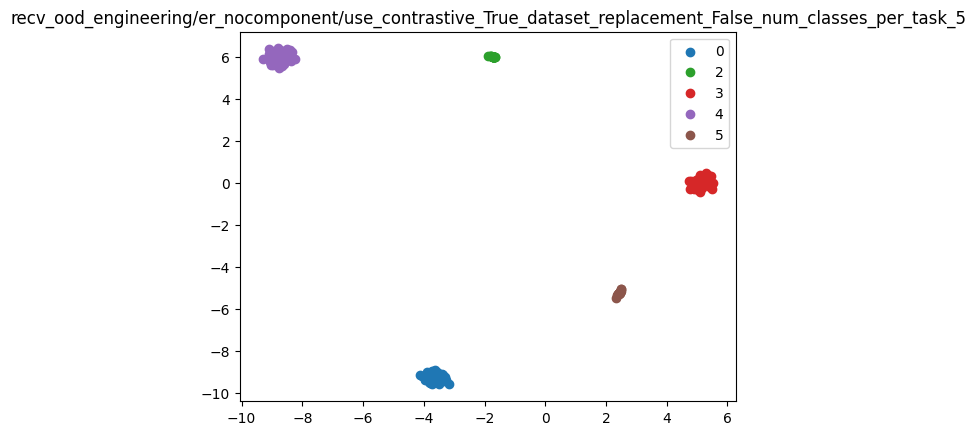

In [21]:
# plot X_embeds with TSNE and color by global_ys
X_embeds_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_embeds)

fig, ax = plt.subplots()

for cls in np.unique(global_ys):
    X_embed_cls = X_embeds_embedded[global_ys == cls]
    color = "C" + str(cls)
    ax.scatter(X_embed_cls[:, 0], X_embed_cls[:, 1], c=color,
            label=cls)
            
ax.legend()
plt.title(path);